# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import math
import cv2
import numpy as np
from statistics import mean
import chess
from scipy import signal
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow

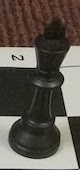

In [3]:
# Example subimage that we are trying to extract and classify using the neural network
training_images_path = '/content/drive/My Drive/chess_data/training_img_dir'
test_piece = cv2.imread(training_images_path + '/bk2.jpg')
cv2_imshow(test_piece)

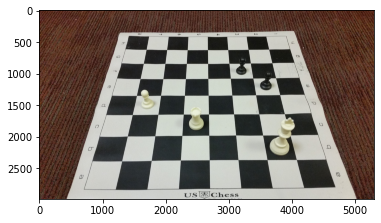

In [4]:
# example board state
boards_images_path = '/content/drive/My Drive/chess_data/images'
original_image_path = boards_images_path + '/5_2.jpg'
test_board = cv2.imread(original_image_path)
test_board = cv2.cvtColor(test_board, cv2.COLOR_BGR2RGB)
plt.imshow(test_board)

# Board Detection

In [5]:
# reads in a file path and return a resized image, and grayscaled image
def read_img(file_path):
  img = cv2.imread(str(file_path))
  img = cv2.resize(img, (960, 540)) 
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img, gray_img

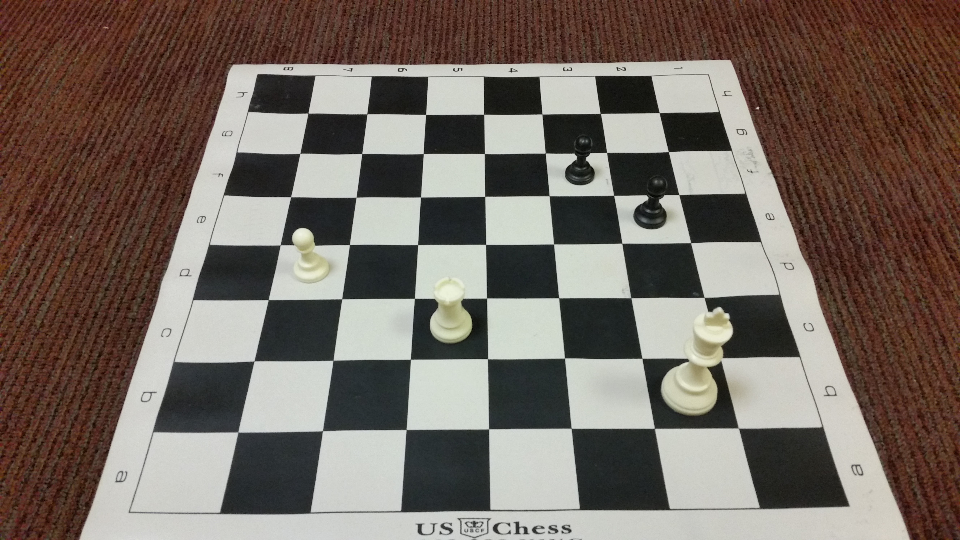

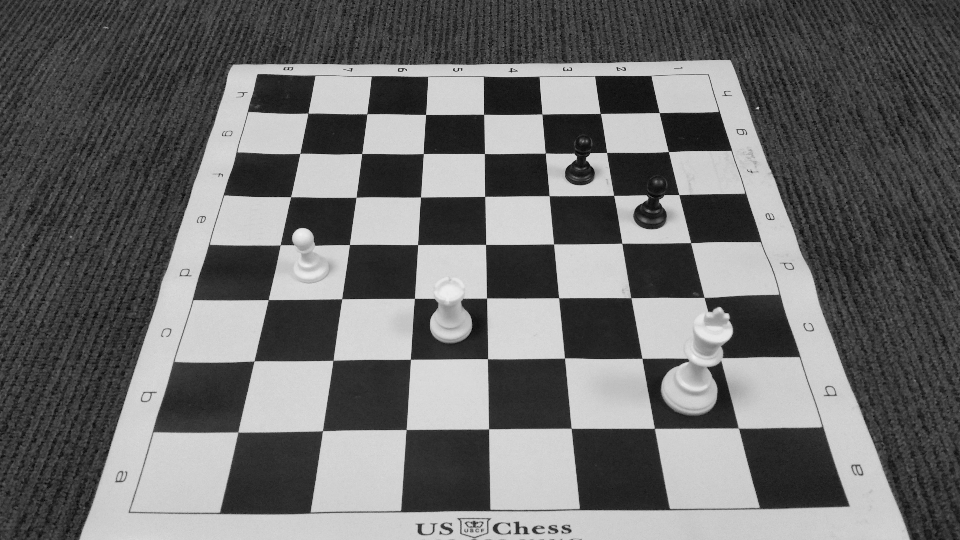

In [6]:
img, gray_img = read_img(original_image_path)
cv2_imshow(img)
cv2_imshow(gray_img)

In [7]:
# crops images based off cordinates
def crop_image(image, points):
    points = points.astype(int)
    ys = points[:,1]
    xs = points[:,0]
    if len(image.shape)==2:
        image = image[int(ys[0]):int(ys[1]), int(xs[0]):int(xs[1])]
    else:
        image = image[int(ys[0]):int(ys[1]), int(xs[0]):int(xs[1]),:]

    return image

In [8]:
points = []
points.append([105, 10])
points.append([885, 535])
points = np.array(points)
cropped_img = crop_image(gray_img, points)
cropped_img_temp = crop_image(img, points)

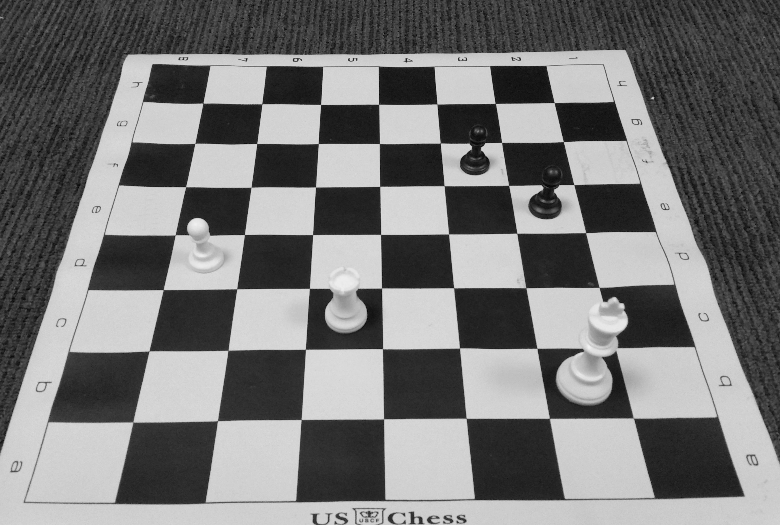

In [9]:
cv2_imshow(cropped_img)

# Canny Edge Detection
* algorithm article https://en.wikipedia.org/wiki/Canny_edge_detector
* implements article while combining double threshold and hysteresis




In [10]:
# gaussian kernel creation for blurring purposes based off of sigma and kernel_size
def gaussian_kernel(kernel_size, sigma):
  window_size = kernel_size*2 +1
  gaussian_kernel_1d = signal.gaussian(window_size, std=sigma).reshape(window_size, 1)
  gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
  gaussian_kernel_2d /= np.sum(gaussian_kernel_2d) # make sure it sums to one

  return gaussian_kernel_2d


# Sobel filter used for edge detection by comparing contrast
# https://en.wikipedia.org/wiki/Sobel_operator
def sobel_filters(img):
  Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

  Ix =  cv2.filter2D(img, -1, Kx)
  Iy =  cv2.filter2D(img, -1, Ky)

  G = np.hypot(Ix, Iy)
  G = G / G.max() * 255

  theta = np.arctan2(Iy, Ix)
  theta = np.rad2deg(theta)
  
  theta[theta<0] += 180
  return (G, theta)


# Non max supression is a form of thining for high constrast images. 
# it angles of gradient derived during the sobel process to check the surroundings 
# and decide whther or not to keep the pixel or not. 
def non_max_suppression(img, angles):
  size = img.shape
  res = np.zeros(size)

  M, N = img.shape
  for i in range(1, M - 1):
      for j in range(1, N - 1):
          # 0 degrees
          if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
              value = max(img[i, j - 1], img[i, j + 1])
          # 45 degrees
          elif (22.5 <= angles[i, j] < 67.5):
              value = max(img[i - 1, j - 1], img[i + 1, j + 1])
          
          # 90 degrees 
          elif (67.5 <= angles[i, j] < 112.5):
              value = max(img[i - 1, j], img[i + 1, j])
          
          # 135 degrees
          else:
              value = max(img[i + 1, j - 1], img[i - 1, j + 1])
          
          if img[i, j] >= value:
              res[i, j] = img[i, j]
  res = np.multiply(res, 255.0 / res.max())
  return res

# this function combines two parts of the Canny edge alogorithm
# it combines the double threshold and hysteresis sections
def double_threshold_hysteresis(img, lowThres = 0.09, highThres = 0.1):
  # double threshold section

  # low and high threshold are used to determine which pixels are zero, weak , or strong
  highThreshold = img.max() * highThres
  lowThreshold = highThreshold * lowThres

  # here we set the output value of strong and weak pixels
  strong_value = np.int32(255)
  weak_value = np.int32(75)
  
  M, N = img.shape
  res = np.zeros((M,N), dtype=np.int32)

  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)

  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

  res[strong_i, strong_j] = strong_value
  res[weak_i, weak_j] = weak_value

  direct_i = np.array((-1, -1, 0, 1, 1, 1, 0, -1))
  direct_j = np.array((0, 1, 1, 1, 0, -1, -1, -1))

  while len(strong_i):
    i = strong_i[0]
    j = strong_j[0]
    strong_i = np.delete(strong_i, 0)
    strong_j = np.delete(strong_j, 0)

    for direction in range(len(direct_i)):
      i_hat = i + direct_i[direction]
      j_hat = j + direct_j[direction]

      if (res[i_hat, j_hat] == weak_value):
        if(i_hat >= 0 & i_hat < M & j_hat >= 0 & j_hat < N):
          res[i_hat, j_hat] = strong_value
          np.append(strong_i, i_hat)
          np.append(strong_j, j_hat)
  res[res != strong_value] = 0
  return res

def line_detection(img, sigma = 1.4, kernel_size = 5):
  img = img.astype(np.float32)
  img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_smoothed = cv2.filter2D(img_temp, -1, gaussian_kernel(kernel_size, sigma))
  img_magnitude, img_angles = sobel_filters(img_smoothed)
  img_supression = non_max_suppression(img_magnitude, img_angles)
  img_final = double_threshold_hysteresis(img_supression)
  return img_final

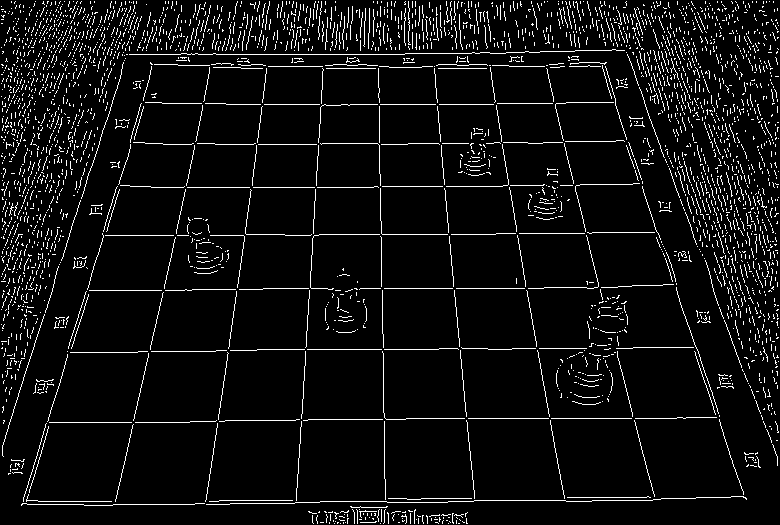

In [11]:
edges = line_detection(cropped_img_temp).astype(np.uint8)
cv2_imshow(edges)

In [12]:
# helper function to draw lines from hough transform onto image
# referenced https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
def display_lines(img, lines):
  lines_img = img.copy()
  for line in lines:
    rho = line[0][0]
    theta = line[0][1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    lines_img = cv2.line(lines_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

  return lines_img

# Hough Transform to Extract Lines

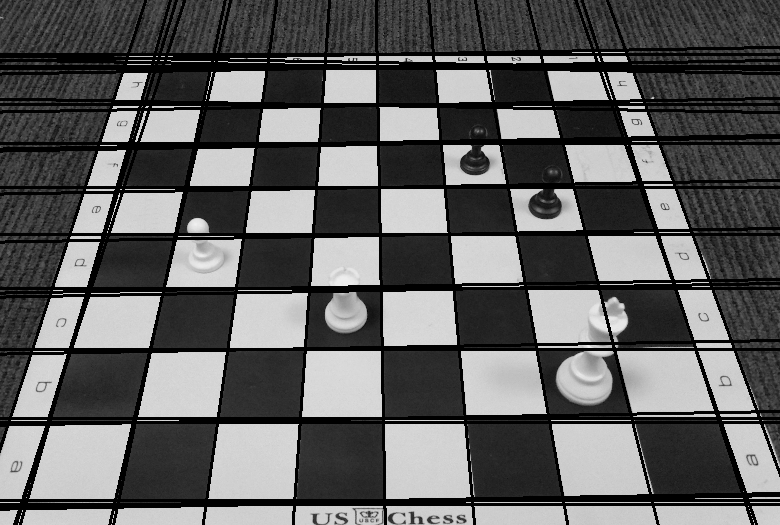

In [13]:
houghlines = cv2.HoughLines(edges, 1, np.pi / 180, 140)
houghlines_img = display_lines(cropped_img, houghlines)
cv2_imshow(houghlines_img)

In [14]:
# splits lines into horizontal and vertical
def split_lines(lines):
  h_lines = []
  v_lines = []
  for line in lines:
    rho = line[0][0]
    theta = line[0][1]
    if theta < np.pi/4 or theta > np.pi - np.pi/4:
      v_lines.append(line)
    else:
      h_lines.append(line)
  
  h_lines = np.array(h_lines)
  v_lines = np.array(v_lines)
  return h_lines, v_lines

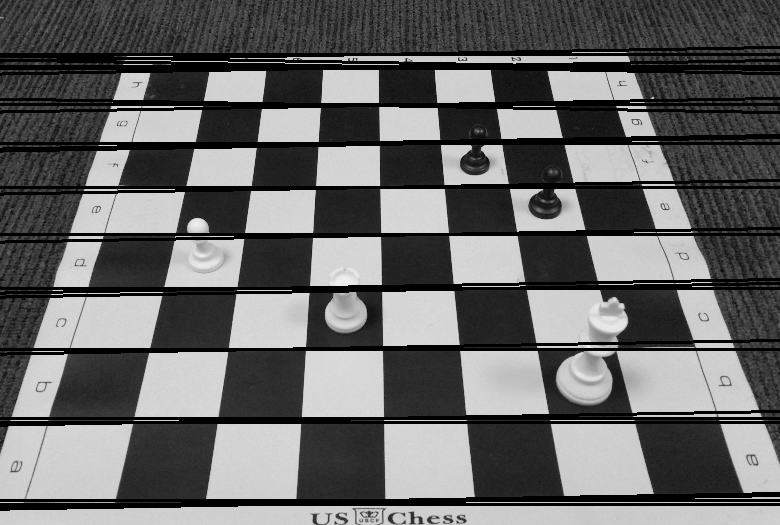

In [15]:
# example showing just the horizontal lines
h_lines, v_lines = split_lines(houghlines)
h_line_img = display_lines(cropped_img, h_lines)
cv2_imshow(h_line_img)

In [16]:
# returns coordinates of intersections between horizontal and vertical linesq
# references: https://en.wikipedia.org/wiki/Hough_transform, line form r = x cosθ + y sinθ, solve linear system

def intersection(h_rho, h_theta, v_rho, v_theta):
    A = np.array([
          [np.cos(h_theta), np.sin(h_theta)],
          [np.cos(v_theta), np.sin(v_theta)]
        ])
    b = np.array([
          [h_rho],
          [v_rho]
        ])
    x, y = np.linalg.solve(A, b)
    x, y = int(np.round(x)), int(np.round(y))

    return np.array([x, y])

def segment_intersections(h_lines, v_lines):
  intersections = []
  for h_line in h_lines:
    for v_line in v_lines:
      intersections.append(intersection(h_line[0][0], h_line[0][1], v_line[0][0], v_line[0][1])) 

  return np.array(intersections)

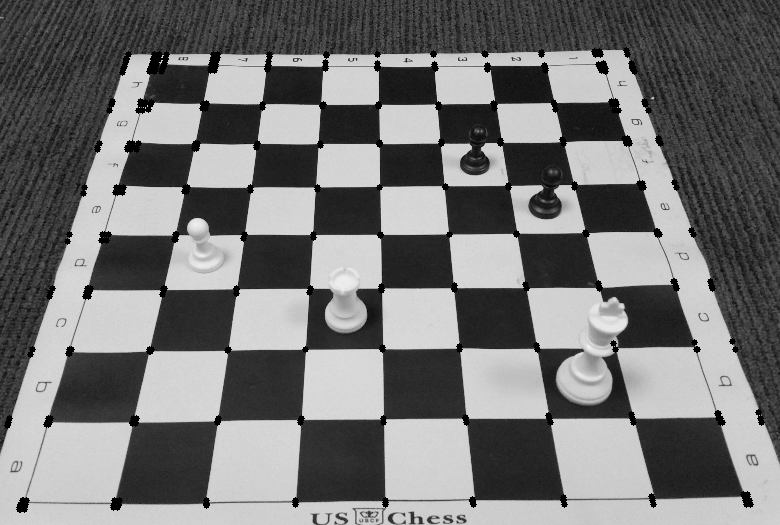

In [17]:
intersections = segment_intersections(h_lines, v_lines)
intersections_img = cropped_img.copy()
for x, y in intersections:
  intersections_img = cv2.circle(intersections_img, (x,y), radius=0, color=(0, 0, 255), thickness=5)

cv2_imshow(intersections_img)

In [18]:
# merge intersections that are close together

def merge_neighboring_points(points, threshold):
    ret = []
    merged = set()
    for idx, point in enumerate(points):
        merge_list = [point]
        if idx not in merged:
          merged.add(idx)
          for idx2, point2 in enumerate(points):
            if idx2 not in merged:
              if ((point[0] - point2[0])**2 + (point[1] - point2[1])**2)**0.5 < threshold:
                  merge_list.append(point2)
                  merged.add(idx2)

          merged_x = mean([x[0] for x in merge_list])
          merged_y = mean([x[1] for x in merge_list])
          ret.append([int(merged_x), int(merged_y)])
    return np.array(ret)

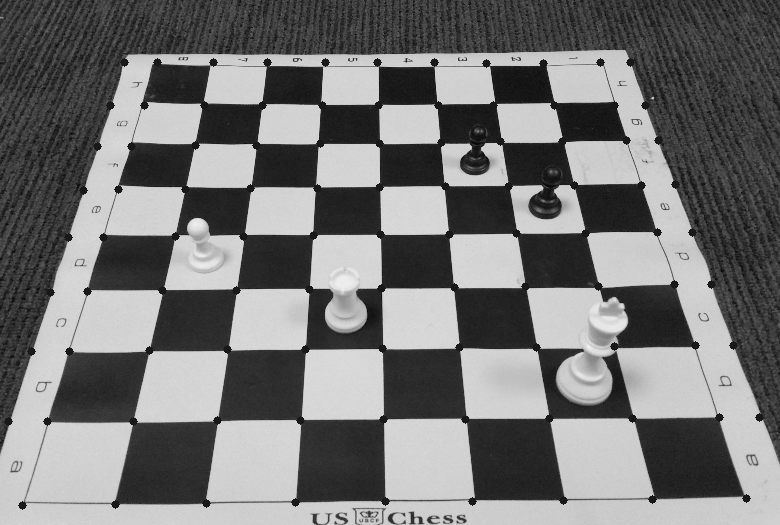

In [19]:
merged_intersections = merge_neighboring_points(intersections, 22)
merged_intersections_img = cropped_img.copy()
for x, y in merged_intersections:
  merged_intersections_img = cv2.circle(merged_intersections_img, (x,y), 4, (25,50,75), -1)

cv2_imshow(merged_intersections_img)

In [20]:
# makes so intersections fall on exact horizontal lines
# hardcoded for the situation above, where there are an exterior column of intersection points
# corresponding to the edge of the chess board
def align_intersections(intersections):
  square_ordered = sorted(intersections, key=lambda x: [x[1], x[0]])
  
  ret = []
  start = 0
  for i in range(10):
    same_y = [square_ordered[start]]
    for i in range(start + 1, len(square_ordered)):
      if abs(square_ordered[i][1] - square_ordered[start][1]) < 10:
        same_y.append(square_ordered[i])
      else:
        start = i
        break
    y_avg = int(mean([x[1] for x in same_y]))
    for point in same_y:
      point[1] = y_avg
      ret.append(point)
    if start != i:
      break
  return ret

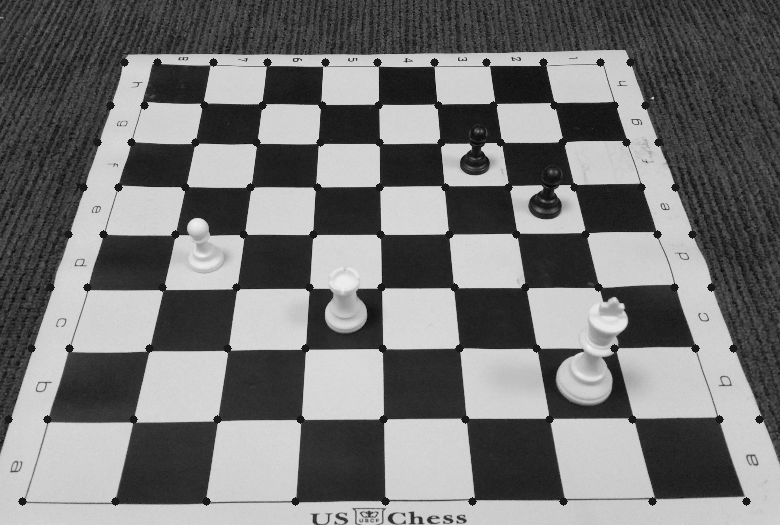

In [21]:
aligned_intersections = align_intersections(merged_intersections)
aligned_intersections_img = cropped_img.copy()
for x, y in aligned_intersections:
  aligned_intersections_img = cv2.circle(aligned_intersections_img, (x,y), 4, (25,50,75), -1)

cv2_imshow(aligned_intersections_img)

In [22]:
# splits chessboard into smaller images based off intersections, 2 boxes high

def split_images(file_name, img, intersections):
  sort_inter = sorted(intersections, key=lambda k: [k[1], k[0]])
  sort_inter = np.array(sort_inter)
  y_vals = set()
  for i in range(sort_inter.shape[0]):
    y_vals.add(sort_inter[i][1])

  test_poly_img = img.copy()
  num_cols = len(y_vals)
  num_rows = int(sort_inter.shape[0]/num_cols)
  count = 0
  for x in range(-1, num_cols - 2):
    for y in range(num_rows - 1):
      if y == 0 or y == num_rows - 2:
        continue

      if x != -1:
        top_left = sort_inter[num_rows*x + y]
        top_right = sort_inter[num_rows*x + y + 1]
        bot_left = sort_inter[(num_rows)*(x+2) + y]
        bot_right = sort_inter[(num_rows)*(x+2) + y + 1]

        pts = np.array([top_left, top_right, bot_right, bot_left], np.int32)
        pts = pts.reshape((-1,1,2))

        top_left_x = min([top_left[0],top_right[0],bot_left[0],bot_right[0]])
        top_left_y = min([top_left[1],top_right[1],bot_left[1],bot_right[1]])
        bot_right_x = max([top_left[0],top_right[0],bot_left[0],bot_right[0]])
        bot_right_y = max([top_left[1],top_right[1],bot_left[1],bot_right[1]])

        cropped = img[top_left_y:bot_right_y, top_left_x:bot_right_x]
        cropped = cv2.resize(cropped, (80, 170)) 
        test_poly_img = cv2.polylines(test_poly_img,[pts],True,(0,255,255), 3)

        cv2.imwrite('/content/drive/My Drive/chess_data/cropped_images/' + file_name + str(count) + '.jpeg', cropped)
        count += 1
      else:
        top_left = sort_inter[num_rows*(x+1) + y]
        top_right = sort_inter[num_rows*(x+1) + y + 1]
        bot_left = sort_inter[(num_rows)*(x+2) + y]
        bot_right = sort_inter[(num_rows)*(x+2) + y + 1]

        temp_top_left = top_left.copy()
        temp_top_left[1] -= 30
        temp_top_right = top_right.copy()
        temp_top_right[1] -= 30
        pts = np.array([temp_top_left, temp_top_right, bot_right, bot_left], np.int32)
        pts = pts.reshape((-1,1,2))

        top_left_x = min([temp_top_left[0],temp_top_right[0],bot_left[0],bot_right[0]])
        top_left_y = min([temp_top_left[1],temp_top_right[1],bot_left[1],bot_right[1]])
        bot_right_x = max([temp_top_left[0],temp_top_right[0],bot_left[0],bot_right[0]])
        bot_right_y = max([temp_top_left[1],temp_top_right[1],bot_left[1],bot_right[1]])

        cropped = img[top_left_y:bot_right_y, top_left_x:bot_right_x]
        cropped = cv2.resize(cropped, (80, 170)) 
        test_poly_img = cv2.polylines(test_poly_img,[pts],True,(0,255,255), 3)

        cv2.imwrite('/content/drive/My Drive/chess_data/cropped_images/' + file_name + str(count) + '.jpeg', cropped)
        count += 1

  return test_poly_img, count

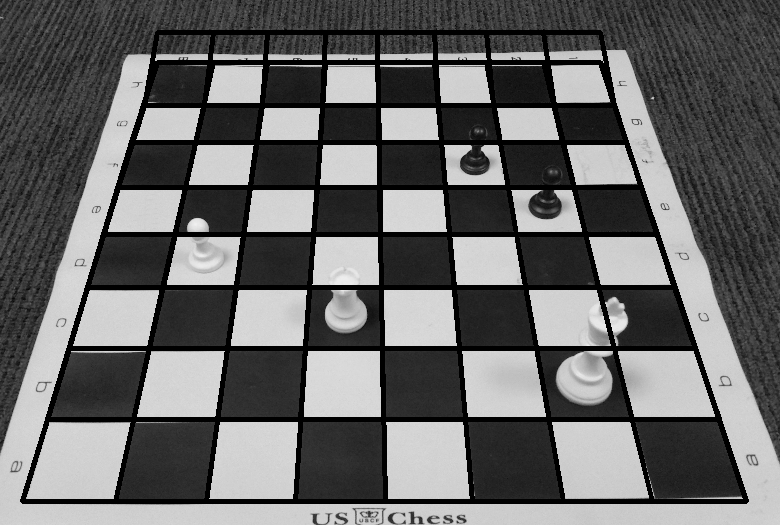

64


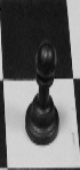

In [23]:
poly_img, split_img_count = split_images('5_2_split', cropped_img, aligned_intersections)
cv2_imshow(poly_img)
# should be 64 images
print(split_img_count)

example_subimage = cv2.imread('/content/drive/My Drive/chess_data/cropped_images/5_2_split21.jpeg')
cv2_imshow(example_subimage)

# Neural Network Setup
### Referenced https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [25]:
# import our chess dataset for use with PyTorch
# chess board data set found at https://github.com/jialinding/ChessVision/tree/master/training_images

class CustomChessDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) / 255.0
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.5), (0.5))])

dataset = CustomChessDataset("/content/drive/My Drive/chess_data/training_labels.csv", "/content/drive/My Drive/chess_data/training_img_dir", transform=transform)
testset = CustomChessDataset("/content/drive/My Drive/chess_data/test_labels.csv", "/content/drive/My Drive/chess_data/testing_img_dir")

trainloader = DataLoader(dataset, batch_size=2, shuffle=True)
testloader = DataLoader(testset, batch_size=2, shuffle=False)


In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(10608, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 17)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net(inputs)
        
        y_pred = net(inputs)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

    print('Epoch {} done'.format(epoch))

print('Finished Training')



Epoch 0 done
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Finished Training


# Classify Subimages and Render Board

In [33]:
convert_tensor = transforms.ToTensor()
board = chess.Board(None)

for square in range(64):
  img_fp = '/content/drive/My Drive/chess_data/cropped_images/5_2_split{}.jpeg'.format(str(square))
  img = cv2.imread(img_fp, cv2.IMREAD_GRAYSCALE)
  tensor = convert_tensor(img)
  tensor = tensor[None, :]
  output = net(tensor)
  _, predicted = torch.max(output, 1)
  predicted = int(predicted)
  color = True
  if predicted == 0:
    continue
  elif predicted > 10:
    color = False
    predicted -= 10

  piece = chess.Piece(predicted, color)


  if square < 8:
    square += 56
  elif 8 <= square < 16:
    square += 40
  elif 16 <= square < 24:
    square += 22
  elif 24 <= square < 32:
    square += 8
  elif 32 <= square < 40:
    square -= 8
  elif 40 <= square < 48:
    square -= 22
  elif 48 <= square < 56:
    square -= 40
  elif 56 <= square < 64:
    square -= 56

  board.set_piece_at(square, piece)


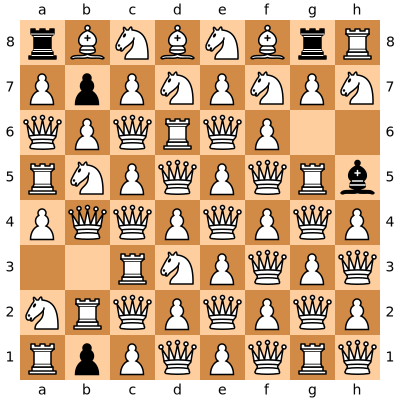

In [34]:
board